In [2]:
pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 11.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
import os
import numpy as np
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive')

# Path to your CT scan dataset in Google Drive
dataset_dir = '/content/drive/MyDrive/jenita'


Mounted at /content/drive


In [21]:
class MHDDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.mhd')]
        self.labels = [0 if 'benign' in f.lower() else 1 for f in os.listdir(root_dir)]  # Adjust labels accordingly

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = sitk.ReadImage(img_path)
        img_array = sitk.GetArrayFromImage(img)
        img_array = img_array[0]  # Assuming 3D image, take the first slice

        # Convert to PIL Image and ensure it is float32
        img_pil = Image.fromarray(img_array.astype(np.float32))

        if self.transform:
            img_pil = self.transform(img_pil)

        return img_pil, label


In [22]:
# Transformations with channel conversion
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset
dataset = MHDDataset(root_dir=dataset_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=20, shuffle=True)


In [23]:
# Define the model (MobileNetV2)
model = models.mobilenet_v2(weights=None)  # Use `weights=None` instead of `pretrained=False`
model.classifier[1] = nn.Linear(model.last_channel, 2)  # Adjust for the number of classes (e.g., 2 for binary classification)
model = model.to(device)


In [24]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [25]:
# Training the model
n_epochs = 10
train_loss = []
train_accuracy = []

for epoch in range(n_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

# Save the model
torch.save(model.state_dict(), 'Tumor_Detection_MobileNetV2.pt')


Epoch [1/10], Loss: 0.0251, Accuracy: 0.9967
Epoch [2/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [3/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [4/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [5/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [6/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [7/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [8/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [9/10], Loss: 0.0000, Accuracy: 1.0000
Epoch [10/10], Loss: 0.0000, Accuracy: 1.0000


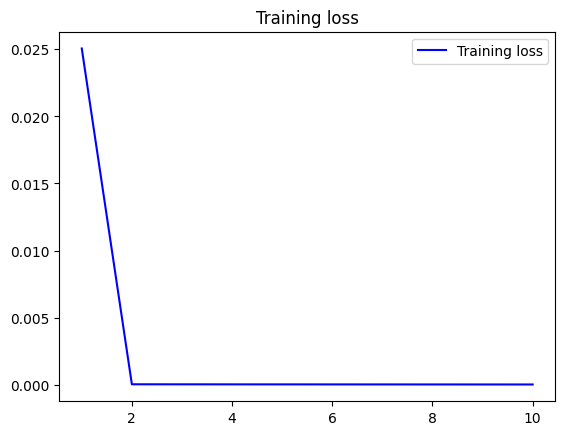

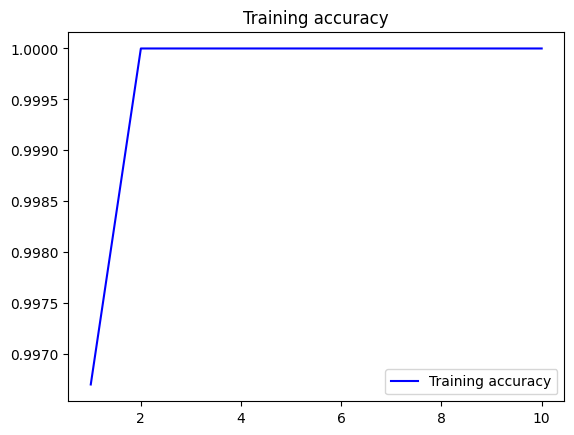

In [26]:
# Plot accuracy and loss
def plot_acc_loss(train_loss, train_accuracy):
    epochs = range(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
    plt.title('Training accuracy')
    plt.legend()

    plt.show()

plot_acc_loss(train_loss, train_accuracy)


In [27]:
# Load the trained model's weights
model.load_state_dict(torch.load('/content/Tumor_Detection_MobileNetV2.pt'))
model.eval()  # Set the model to evaluation mode

# Define the image preprocessing steps for inference
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel if necessary
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_image(image_path):
    """Load and preprocess the image."""
    image = sitk.ReadImage(image_path)
    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array[0]  # Assuming 3D image, take the first slice
    img_pil = Image.fromarray(img_array.astype(np.float32))
    image = preprocess(img_pil)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)

def predict(image_path, model):
    """Predicts the class of an image."""
    image = load_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
    return predicted.item()

# Get class names from directory structure
class_names = ['benign', 'malignant']  # Adjust according to your labels

image_path = '/content/drive/MyDrive/jenita/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860 - Copy.mhd'  # Replace with your image path
predicted_class = predict(image_path, model)
predicted_class_name = class_names[predicted_class]

print(f'Predicted Class: {predicted_class_name}')


Predicted Class: malignant
